# Modeling the Glucose-Insulin system

#### Bonnie Cooper
<br><br>  

## Implement the minimal model of glucose and insulin in the blood stream.

### Definitions: The Glucose-Insulin System

**Glucose** a form of sugar that circulates in the blood stream of animals and is metabolized as the most common fuel for typical cellular processes.  
**Insulin** a hormone produced by the pancreas that acts to lower blood glucose levels.  
**Hyperglycemia** when blood sugar levels become elevated.
**Hypoglycemia** when blood sugar levels are depressed.
**Diabetes Mellitus** a condition characterized by hyperglycemia because the body does not produce enough insulin &/or does not properly respond to the insulin that the body produces.
**Frequently Sampled Intravenous Glucose Tolerance Test (FSIGT)** one of the most common tests for hyperglycemia &/or diabetes mellitus. a glucose injection is administered to a fasting subject. subsequently, a series of blood samples are drawn in intervals for several hours. from these samples, blood glucose measurements are obtained which describes the subjects ability to metabolize glucose.

### The Glucose Minimal Model
The Minimal Model is a model in two parts: the glucose model and the insulin model. First described by Bergman *et al* (1), the model seeks 'the simplest model based on known physiology that could account for the insulin-glucose relationship revealed in the data.' The goal of this model is to estimate the model parameters given a dataset and to be ableto interpret the model parameters meanigfully. Blood glucose levels are modeled to decrease in the blood due to two main effects: the blood glucose's natural tendancy to normalize in concentraion and the effects of insulin. Insulin if found to have a relatively longer latency to action.  

The Glucose Minimal Model consists of 2 differential equations:

1. $$ \frac{dG}{dt} = -k_1[G(t) - G_b] - X(t)G(t)$$
2. $$ \frac{dX}{dt} = k_3[I(t) - I_b] - k_2X(t)$$ 

where  
* $G$ [ blood glucose ] as a function of time
* $X$ [ insulin ] as a function of time
* $I$ [ insulin ] as a function of time measured from the patient
* $G_b$ & $I_b$ [ blood glucose ] & [ insulin ] basal at equilibrium
* $\frac{dG}{dt}$ & $\frac{dX}{dt}$ rates of change
* $k_1$, $K_2$ and $k_3$ model parameters

We can interpret the equations as follows:
1. the rate of change of blood glucose concentration as a function of time can be described by the rate of glucose disappearance due to the effects of glucose itself and the rate of glucose disappearance due to the effects of insulin
2. the rate of change of blood insulin concentration as a function of time can be described by the rate that insulin diffuses from blood to interstitial fluid and the rate that insulin is broken down in tissue.

### the Data

To test the Minimal Model, data from Pacini & Bergman (3) will be used.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read data to a pandas dataframe
data = pd.read_csv( 'https://raw.githubusercontent.com/SmilodonCub/ModSimPy/master/notebooks/data/glucose_insulin.csv', index_col='time' )
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


Text(0.5, -0.05, 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity')

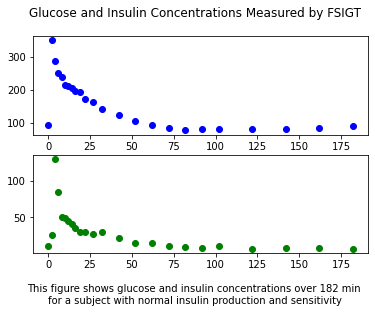

In [21]:
txt = 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity'
fig, axs = plt.subplots(2);
fig.suptitle('Glucose and Insulin Concentrations Measured by FSIGT');
axs[0].plot(data.index, data['glucose'], 'ob');
axs[1].plot(data.index, data['insulin'], 'og');
fig.text(.5, -0.05, txt, ha='center')

### Interpolation
The Pacini & Bergman data is a series of discrete timepoint measurements. Before we can implement the model, the data points need to be interpolated. **Interpolation** is a mathematical method that estimates values inbetween the given data points.

In [32]:
from scipy import interpolate as int
import numpy as np

In [45]:
I = int.interp1d( data.index, data.insulin, kind = 'linear')
G = int.interp1d( data.index, data.glucose, kind = 'linear')

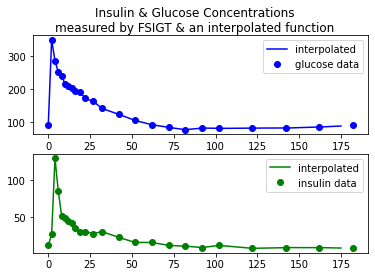

In [50]:
ts = np.linspace( 0, 175, num = 176, endpoint=True )

fig, axs = plt.subplots(2);
fig.suptitle('Insulin & Glucose Concentrations\nmeasured by FSIGT & an interpolated function');
axs[1].plot( ts, I(ts), 'g', label = 'interpolated');
axs[1].plot( data.index, data['insulin'], 'og', label = 'insulin data');
axs[1].legend()
axs[0].plot( ts, G(ts), 'b', label = 'interpolated');
axs[0].plot( data.index, data['glucose'], 'ob', label = 'glucose data');
axs[0].legend();

## The Glucose Model

In [122]:
class Params:
    """ Params class represents a collection of parameters. """

    def __init__(self, G0, k1, k2, k3):
        """ Create a new set of parameters """
        self.G0 = G0
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        
class State:
    """State class represents the current state of the minimal model"""
    
    def __init__( self, G, X ):
        """Initialize State"""
        self.G = G
        self.X = X
        
class System:
    """Sytem class represents the minimal model system"""
    
    def __init__( self, params, initState, Gb, Ib, I, t_0, t_end, dt, k1, k2, k3 ):
        """Initialize System"""
        self.params = params
        self.initState = initState
        self.Gb = Gb
        self.Ib = Ib
        self.I = I
        self.t_0 = t_0
        self.t_end = t_end
        self.dt = dt
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3

In [220]:
def make_system( params, data, timeStep ):
    """
    uses initial measurements from params & data to initialize a system
    params: a Params object
    data: a pandas dataframe
    timeStep: discrete time interval of data (mins)
    requires interpolate from scipy
    """
    dt = timeStep
    
    G0 = params.G0
    k1 = params.k1
    k2 = params.k2
    k3 = params.k3
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = int.interp1d( data.index, data.insulin, kind = 'linear') 
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    initState = State( G = G0, X=0 )
    
    return System( params, initState=initState, Gb=Gb, Ib=Ib, I=I, t_0=t_0, \
                  t_end=t_end, dt=dt, k1=k1, k2=k2, k3=k3 )

def update_func( state, t, system ):
    """
    Update the state of the system for a given increment of time
    state = a State() object
    system = a System() object
    """
    G, X = state.G, state.X
    k1, k2, k3 = system.k1, system.k2, system.k3
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * ( G-Gb ) - X*G
    dXdt = k3 * ( I(t)-Ib ) - k2*X
    
    G += dGdt*dt
    X += dXdt*dt
    
    return State( G=G, X=X )

def run_simulation( system, update_func ):
    """
    rum minimal model simulation
    """
    init = system.initState
    print( vars(init) )
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    num_steps = np.arange( t_0, t_end+dt, dt )
    #index_step = np.linspace( 0, len(num_steps), len(num_steps)+1, endpoint = True )
    resultSeries = np.empty( [len( num_steps),2] )
    resultSeries[ 0,0 ] = init.G
    resultSeries[ 0,1 ] = init.X
    #print( resultSeries)
    
    for aStep in range( len(num_steps)-1 ):
        currentState = State( G=resultSeries[ aStep, 0 ], X=resultSeries[ aStep, 1 ])
        nextState = update_func( currentState, num_steps[aStep], system )
        resultSeries[ aStep + 1,0 ] = nextState.G
        resultSeries[ aStep + 1,1 ] = nextState.X
        #print( 'Timestep:', aStep )
        #print( 'Current:', currentState.G, currentState.X )
        #print( 'Next', nextState.G, nextState.X )
    
    data = {'time': num_steps, 'G':resultSeries[:,0], 'X':resultSeries[:,1]}
    results_df = pd.DataFrame(data)
    return results_df   

In [100]:
params = Params( G0=290, k1 = 0.03, k2 = 0.02, k3 = 1e-05 )
print( vars( params ) )

{'G0': 290, 'k1': 0.03, 'k2': 0.02, 'k3': 1e-05}


In [153]:
aSys = make_system( params, data, 2 )

In [149]:
nextState = update_func( aSys.initState, aSys.t_0, aSys )
vars( nextState )

{'G': 278.12, 'X': 0.0}

In [224]:
a = run_simulation( aSys, update_func );
a

{'G': 290, 'X': 0}


,time,G,X
0,0,290.000000,0.000000
1,2,278.120000,0.000000
2,4,266.952800,0.000300
3,6,256.295460,0.002668
4,8,245.070140,0.004041
...,...,...,...
87,174,91.044781,-0.000631
88,176,91.217018,-0.000678
89,178,91.387668,-0.000725
90,180,91.556880,-0.000772


In [217]:
num_steps = np.arange( 0, 182+2, 2 )
index_step = np.linspace( 0, len(num_steps), len(num_steps)+1, endpoint = True )
print(len(num_steps))
len(index_step)

92


93

## References

1. Bergman, Richard N. "Minimal model: perspective from 2005." Hormone Research in Paediatrics 64.Suppl. 3 (2005): 8-15.
2. [CDC National Diabetes Statistics Report 2020](https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report.pdf)
3. Pacini, Giovanni, and Richard N. Bergman. "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test." Computer methods and programs in biomedicine 23.2 (1986): 113-122.